In [2]:
# Bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from sklearn.linear_model import BayesianRidge
import warnings
warnings.filterwarnings('ignore')

print("=== VALIDAÇÃO CRUZADA K-FOLD ===\n")

=== VALIDAÇÃO CRUZADA K-FOLD ===



In [3]:
# 1. CARREGAR DADOS
def load_boston_data():
    """Carrega dataset similar ao Boston Housing"""
    try:
        california = fetch_california_housing()
        dt = pd.DataFrame(california.data, columns=california.feature_names)
        dt['medv'] = california.target * 100000
        return dt
    except:
        np.random.seed(42)
        n_samples = 506
        dt = pd.DataFrame({
            'crim': np.random.exponential(1, n_samples),
            'zn': np.random.randint(0, 100, n_samples),
            'indus': np.random.uniform(2, 30, n_samples),
            'chas': np.random.choice([0, 1], n_samples),
            'nox': np.random.uniform(0.3, 0.9, n_samples),
            'rm': np.random.uniform(3, 9, n_samples),
            'age': np.random.uniform(20, 100, n_samples),
            'dis': np.random.exponential(3, n_samples),
            'rad': np.random.randint(1, 25, n_samples),
            'tax': np.random.randint(200, 700, n_samples),
            'ptratio': np.random.uniform(12, 23, n_samples),
            'black': np.random.uniform(300, 400, n_samples),
            'lstat': np.random.uniform(1, 40, n_samples),
            'medv': np.random.normal(20000, 10000, n_samples)
        })
        return dt

dt = load_boston_data()
print(f"Dataset shape: {dt.shape}")

Dataset shape: (20640, 9)


In [4]:
# 2. CONFIGURAÇÃO K-FOLD
K = 5
kf = KFold(n_splits=K, shuffle=True, random_state=42)

# Inicializar arrays para armazenar previsões
yhat_lm = np.full(len(dt), np.nan)
yhat_RF = np.full(len(dt), np.nan)
yhat_RNA = np.full(len(dt), np.nan)
yhat_MLP = np.full(len(dt), np.nan)

print(f"Iniciando validação cruzada {K}-fold...\n")

Iniciando validação cruzada 5-fold...



In [6]:
# 3. LOOP K-FOLD
for i, (train_index, test_index) in enumerate(kf.split(dt)):
    print(f"Fold {i+1}/{K}")

    # Separar dados
    dtTrain = dt.iloc[train_index]
    dtVal = dt.iloc[test_index]

    # Preparar features (adicionar termo quadrático)
    X_train = dtTrain.drop('medv', axis=1).copy()
    y_train = dtTrain['medv']
    X_val = dtVal.drop('medv', axis=1).copy()
    y_val = dtVal['medv']

    #X_train['lstat_squared'] = X_train['lstat'] ** 2
    #X_val['lstat_squared'] = X_val['lstat'] ** 2

    # (1) REGRESSÃO LINEAR
    modelo_lm = LinearRegression()
    modelo_lm.fit(X_train, y_train)
    yhat_lm[test_index] = modelo_lm.predict(X_val)

    # (2) RANDOM FOREST
    modelo_RF = RandomForestRegressor(n_estimators=100, random_state=42)
    modelo_RF.fit(X_train, y_train)
    yhat_RF[test_index] = modelo_RF.predict(X_val)

    # (3) REDE NEURAL COM KERAS
    # Normalização
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    y_train_mean = y_train.mean()
    y_train_std = y_train.std()
    y_train_scaled = (y_train - y_train_mean) / y_train_std

    # Callbacks
    early_stopping = callbacks.EarlyStopping(
        monitor='val_loss', patience=10, restore_best_weights=True
    )
    reduce_lr = callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=5
    )

    # Modelo RNA
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

    # Treinamento
    history = model.fit(
        X_train_scaled, y_train_scaled,
        validation_data=(X_val_scaled, (y_val - y_train_mean) / y_train_std),
        epochs=500, batch_size=64,
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )

    yhat_RNA_scaled = model.predict(X_val_scaled, verbose=0).flatten()
    yhat_RNA[test_index] = yhat_RNA_scaled * y_train_std + y_train_mean

    # (4) MODELO BAYESIANO (alternativo ao Stan)
    modelo_bayes = BayesianRidge()
    modelo_bayes.fit(X_train_scaled, y_train)
    yhat_MLP[test_index] = modelo_bayes.predict(X_val_scaled)

    print(f"  Fold {i+1} concluído")

print("\nValidação cruzada concluída!")

Fold 1/5
  Fold 1 concluído
Fold 2/5
  Fold 2 concluído
Fold 3/5
  Fold 3 concluído
Fold 4/5
  Fold 4 concluído
Fold 5/5
  Fold 5 concluído

Validação cruzada concluída!


In [7]:
# 4. CÁLCULO DAS MÉTRICAS FINAIS
y_true = dt['medv']
n = len(y_true)

def calcular_rmse(y_true, y_pred):
    mask = ~np.isnan(y_pred)  # Ignorar valores NaN
    return np.sqrt(np.mean((y_pred[mask] - y_true[mask]) ** 2))

s_lm = calcular_rmse(y_true, yhat_lm)
s_RF = calcular_rmse(y_true, yhat_RF)
s_RNA = calcular_rmse(y_true, yhat_RNA)
s_MLP = calcular_rmse(y_true, yhat_MLP)

In [8]:
# 5. RESULTADOS E COMPARAÇÃO
resultados_kfold = pd.DataFrame({
    'Modelo': ['Regressão Linear', 'Random Forest', 'RNA Keras', 'Bayesiano'],
    'RMSE': [s_lm, s_RF, s_RNA, s_MLP]
})

print("\n=== RESULTADOS K-FOLD ===")
print(resultados_kfold.round(4))


=== RESULTADOS K-FOLD ===
             Modelo        RMSE
0  Regressão Linear  72840.4053
1     Random Forest  50385.3251
2         RNA Keras  51232.9631
3         Bayesiano  72840.0169


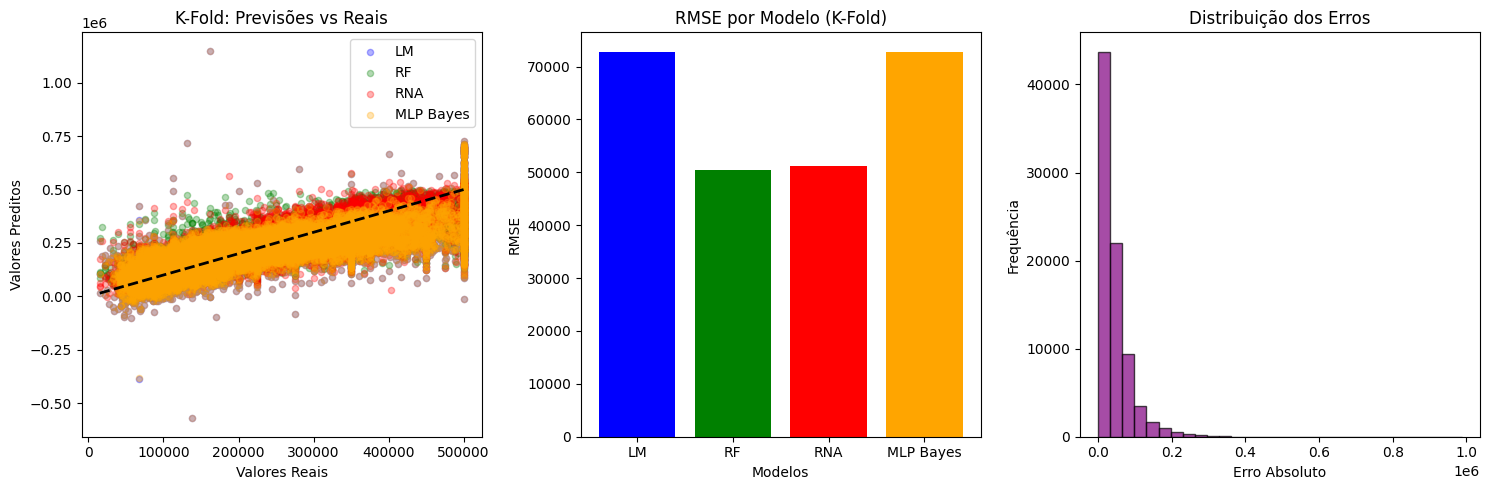

In [9]:
# 6. VISUALIZAÇÃO DOS RESULTADOS
plt.figure(figsize=(15, 5))

# Gráfico 1: Previsões vs Reais
plt.subplot(1, 3, 1)
modelos_pred = [yhat_lm, yhat_RF, yhat_RNA, yhat_MLP]
nomes = ['LM', 'RF', 'RNA', 'MLP Bayes']
cores = ['blue', 'green', 'red', 'orange']

for y_pred, nome, cor in zip(modelos_pred, nomes, cores):
    mask = ~np.isnan(y_pred)
    plt.scatter(y_true[mask], y_pred[mask], alpha=0.3, label=nome, s=20, color=cor)

plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=2)
plt.xlabel('Valores Reais')
plt.ylabel('Valores Preditos')
plt.title('K-Fold: Previsões vs Reais')
plt.legend()

# Gráfico 2: RMSE Comparativo
plt.subplot(1, 3, 2)
plt.bar(nomes, [s_lm, s_RF, s_RNA, s_MLP], color=cores)
plt.xlabel('Modelos')
plt.ylabel('RMSE')
plt.title('RMSE por Modelo (K-Fold)')

# Gráfico 3: Distribuição dos Erros
plt.subplot(1, 3, 3)
erros = []
for y_pred in modelos_pred:
    mask = ~np.isnan(y_pred)
    erros.extend(np.abs(y_true[mask] - y_pred[mask]))

plt.hist(erros, bins=30, alpha=0.7, color='purple', edgecolor='black')
plt.xlabel('Erro Absoluto')
plt.ylabel('Frequência')
plt.title('Distribuição dos Erros')

plt.tight_layout()
plt.show()

In [10]:
# 7. SALVAR RESULTADOS
try:
    # Tentar carregar resultados existentes
    resultados_existentes = pd.read_excel('Resultado_kFold.xlsx')
    resultados_completos = pd.concat([resultados_existentes, resultados_kfold], ignore_index=True)
except:
    resultados_completos = resultados_kfold

resultados_completos.to_excel('Resultado_kFold.xlsx', index=False)
print("\nResultados salvos em 'Resultado_kFold.xlsx'")


Resultados salvos em 'Resultado_kFold.xlsx'


In [11]:
# 8. ANÁLISE DETALHADA POR FOLD
print("\n=== ANÁLISE DETALHADA POR FOLD ===")

# Calcular métricas por fold
fold_results = []
for i, (train_index, test_index) in enumerate(kf.split(dt)):
    y_true_fold = dt.iloc[test_index]['medv']

    # Coletar previsões deste fold
    y_lm_fold = yhat_lm[test_index]
    y_rf_fold = yhat_RF[test_index]
    y_rna_fold = yhat_RNA[test_index]
    y_mlp_fold = yhat_MLP[test_index]

    # Calcular RMSE por fold
    rmse_lm = np.sqrt(mean_squared_error(y_true_fold, y_lm_fold))
    rmse_rf = np.sqrt(mean_squared_error(y_true_fold, y_rf_fold))
    rmse_rna = np.sqrt(mean_squared_error(y_true_fold, y_rna_fold))
    rmse_mlp = np.sqrt(mean_squared_error(y_true_fold, y_mlp_fold))

    fold_results.append({
        'Fold': i+1,
        'LM': rmse_lm,
        'RF': rmse_rf,
        'RNA': rmse_rna,
        'MLP_Bayes': rmse_mlp
    })

fold_df = pd.DataFrame(fold_results)
print("\nRMSE por Fold:")
print(fold_df.round(4))

print(f"\nRMSE Médio por Modelo:")
print(fold_df.mean().round(4))

print("\n=== VALIDAÇÃO CRUZADA CONCLUÍDA ===")


=== ANÁLISE DETALHADA POR FOLD ===

RMSE por Fold:
   Fold          LM          RF         RNA   MLP_Bayes
0     1  74558.1383  50534.2087  51072.7487  74554.0707
1     2  72639.9515  50806.5109  51459.0729  72640.4257
2     3  71364.0813  50573.1872  51144.2367  71365.8313
3     4  71052.8520  48696.6267  49961.5836  71052.8585
4     5  74510.4340  51277.5625  52495.0277  74510.4610

RMSE Médio por Modelo:
Fold             3.0000
LM           72825.0914
RF           50377.6192
RNA          51226.5339
MLP_Bayes    72824.7294
dtype: float64

=== VALIDAÇÃO CRUZADA CONCLUÍDA ===
